# Data Visualization and Statistics
Examines the raw training and test data, as well as new data pulled from external sources

In [2]:
# All imports
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import utils
import matplotlib.pyplot as plt

# Raw training and test data

In [3]:
# Load raw data
raw_train_df = pd.read_csv(utils.RAW_TRAIN_PATH, dtype={"accession": str, "score": float})
raw_test_df = pd.read_csv(utils.RAW_TEST_PATH, dtype={"accession": str, "score": float})

In [ ]:
# # load top 10 most populated scoresets

# Filter only top scoresets
top_sets = raw_train_df["scoreset"].value_counts().head(10).index
subset = raw_train_df[raw_train_df["scoreset"].isin(top_sets)].dropna(subset=["score"])

C:\Users\brady\AppData\Local\Temp\ipykernel_23416\3422250935.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=6, title="scoreset")


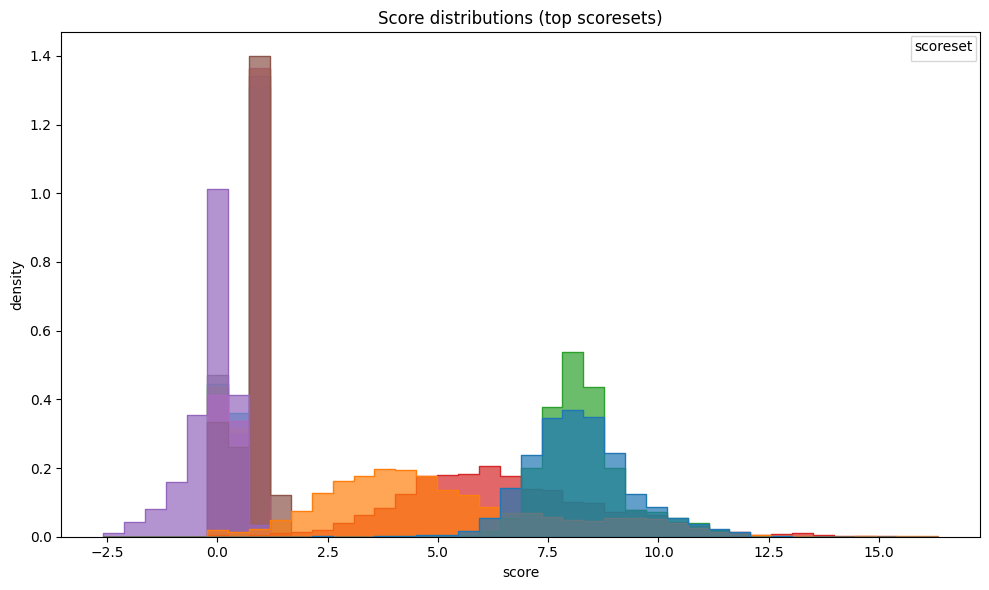

In [ ]:
# # --- Raw score distributions (shape + scale differ by assay) ---

plt.figure(figsize=(10,6))
sns.histplot(
    data=subset,
    x="score",
    hue="scoreset",
    bins=40,
    element="step",     # outlines instead of filled bars
    stat="density",     # equivalent to density=True
    common_norm=False,  # don’t normalize across groups
    alpha=0.7
)

plt.xlabel("score")
plt.ylabel("density")
plt.title("Score distributions (top scoresets)")
plt.legend(fontsize=6, title="scoreset")
plt.tight_layout()
plt.show()

C:\Users\brady\AppData\Local\Temp\ipykernel_23416\3002131880.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=6, title="scoreset")


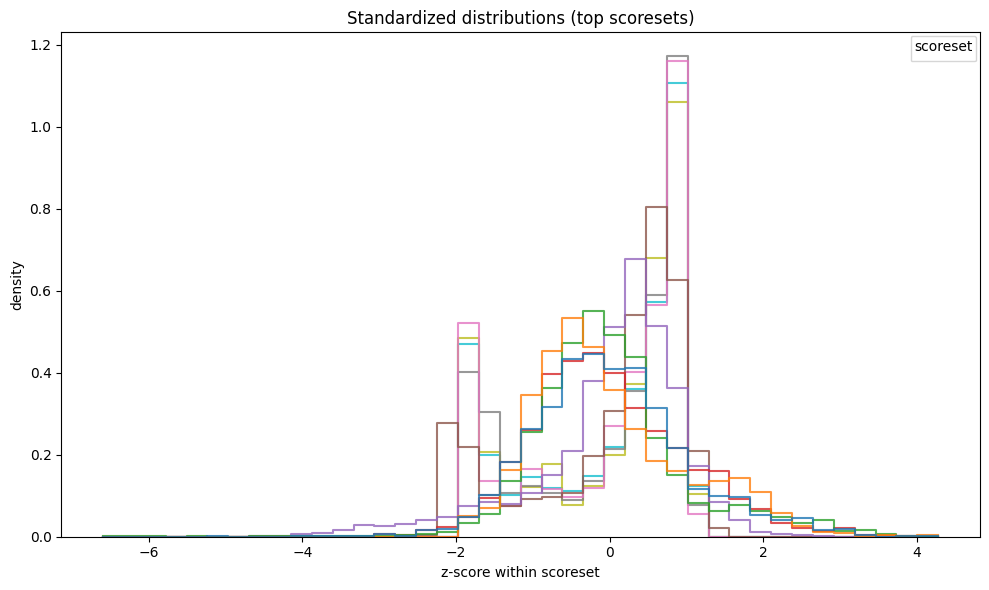

In [ ]:
# # --- Standardized (z-scored) per scoreset: compare shapes only ---

# Keep only the top scoresets and non-NaN scores
subset = raw_train_df[raw_train_df["scoreset"].isin(top_sets)].dropna(subset=["score"]).copy()

# Per-scoreset stats with population std (ddof=0) to match your code exactly
stats = (
    subset.groupby("scoreset")["score"]
          .agg(mean=lambda s: np.mean(s),
               std=lambda s: np.std(s, ddof=0),
               count="size")
          .reset_index()
)

# Filter out groups with <5 samples or zero variance
good = stats[(stats["count"] >= 5) & (stats["std"] > 0)]

# Merge back and compute z-scores within each scoreset
subset = subset.merge(good[["scoreset", "mean", "std"]], on="scoreset", how="inner")
subset["z"] = (subset["score"] - subset["mean"]) / subset["std"]

# Plot: overlaid step histograms (density per group)
plt.figure(figsize=(10, 6))
sns.histplot(
    data=subset,
    x="z",
    hue="scoreset",
    bins=40,
    stat="density",       # like density=True
    common_norm=False,    # normalize each scoreset separately
    element="step",       # step outline (like histtype='step')
    fill=False,
    multiple="layer",
    alpha=0.8
)
plt.xlabel("z-score within scoreset")
plt.ylabel("density")
plt.title("Standardized distributions (top scoresets)")
plt.legend(fontsize=6, title="scoreset")
plt.tight_layout()
plt.show()

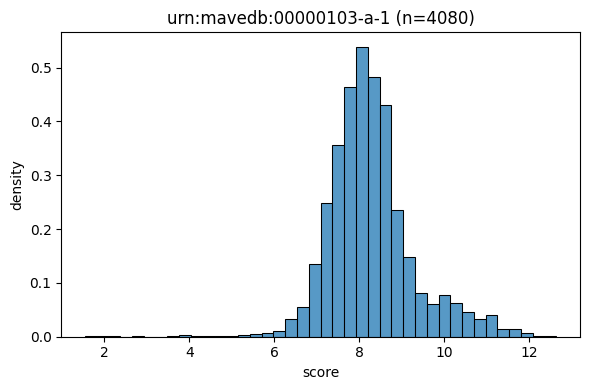

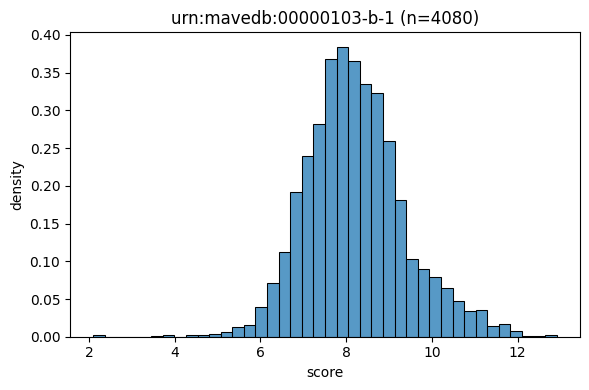

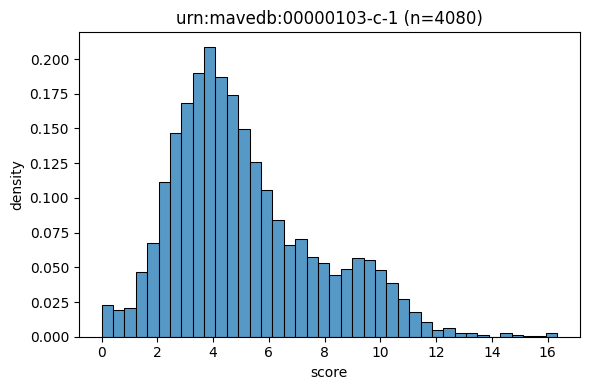

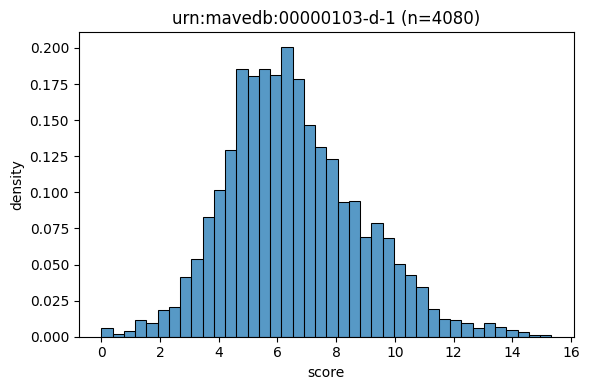

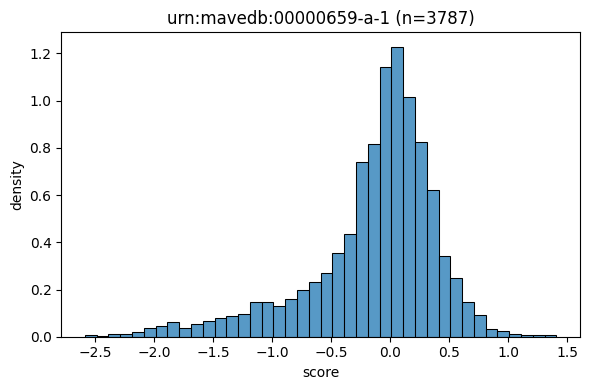

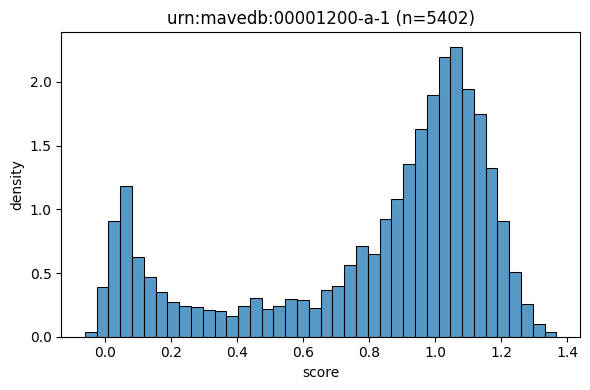

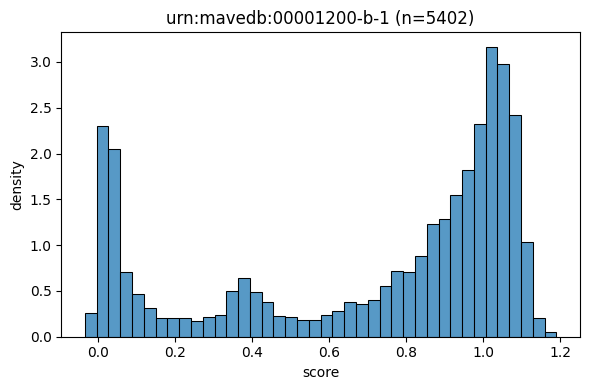

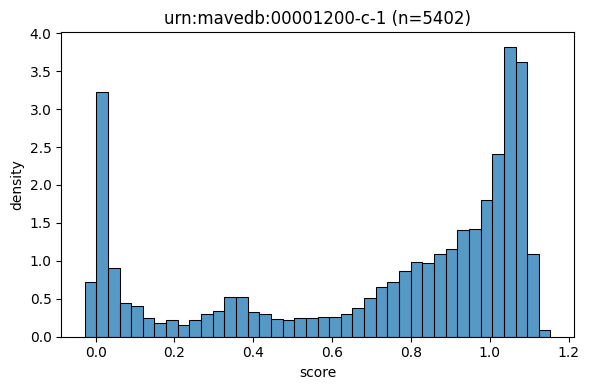

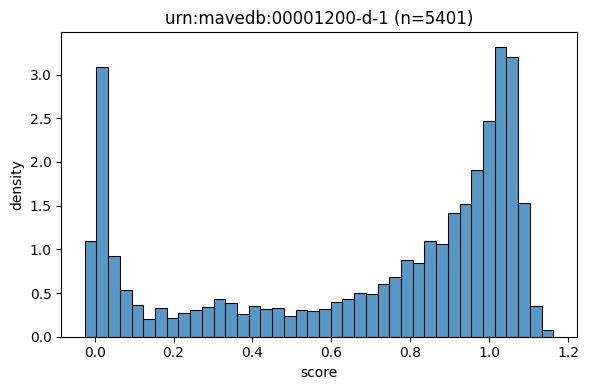

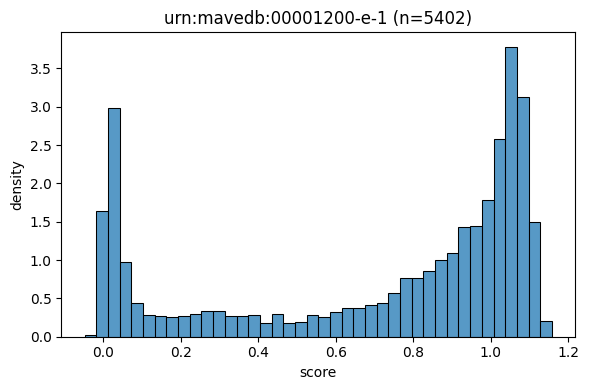

In [12]:
# Display scoresets seperately

# assume: raw_train_df, top_sets defined
subset = (
    raw_train_df[raw_train_df["scoreset"].isin(top_sets)]
    .dropna(subset=["score"])
)

def safe_name(s: str) -> str:
    return re.sub(r'[\\/:*?"<>|#]+', "_", str(s)).strip("_")

# one figure per scoreset
for s, grp in subset.groupby("scoreset"):
    if len(grp) < 5:
        continue
    plt.figure(figsize=(6,4))
    sns.histplot(data=grp, x="score", bins=40, stat="density")
    plt.xlabel("score"); plt.ylabel("density")
    plt.title(f"{s} (n={len(grp)})")
    plt.tight_layout()
    # Optional save:
    # out = Path("figs"); out.mkdir(exist_ok=True, parents=True)
    # plt.savefig(out / f"dist_{safe_name(s)}.png", dpi=200)
    plt.show()
